In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.sdes as sdes
import model.discrete_diffusers as discrete_diffusers
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

cont_model_path = os.path.join(models_base_path, "mnist_continuous_alldigits/2/epoch_90_ckpt.pth")
disc_model_path = os.path.join(models_base_path, "mnist_discrete_alldigits/2/epoch_200_ckpt.pth")

In [5]:
classes = list(range(10))

cont_branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.4854854854854855, 1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 0.44744744744744747, 0.4854854854854855), ((2, 3, 4, 5, 6, 7, 8, 9), 0.43343343343343343, 0.44744744744744747), ((2, 3, 4, 5, 7, 8, 9), 0.4164164164164164, 0.43343343343343343), ((3, 4, 5, 7, 8, 9), 0.3743743743743744, 0.4164164164164164), ((3, 4, 5, 8, 9), 0.3683683683683684, 0.3743743743743744), ((3, 4, 5, 9), 0.35235235235235235, 0.3683683683683684), ((3, 4, 5), 0.3483483483483483, 0.35235235235235235), ((3, 5), 0.27127127127127126, 0.3483483483483483), ((0,), 0, 0.4854854854854855), ((1,), 0, 0.44744744744744747), ((6,), 0, 0.43343343343343343), ((2,), 0, 0.4164164164164164), ((7,), 0, 0.3743743743743744), ((8,), 0, 0.3683683683683684), ((9,), 0, 0.35235235235235235), ((4,), 0, 0.3483483483483483), ((5,), 0, 0.27127127127127126), ((3,), 0, 0.27127127127127126)]
disc_branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 761, 1000), ((0, 2, 3, 4, 5, 6, 7, 8, 9), 760, 761), ((2, 3, 4, 5, 6, 7, 8, 9), 712, 760), ((3, 4, 5, 6, 7, 8, 9), 709, 712), ((3, 5, 6, 8), 700, 709), ((4, 7, 9), 685, 709), ((3, 5, 8), 659, 700), ((3, 5), 656, 659), ((4, 9), 527, 685), ((1,), 0, 761), ((0,), 0, 760), ((2,), 0, 712), ((6,), 0, 700), ((7,), 0, 685), ((8,), 0, 659), ((5,), 0, 656), ((3,), 0, 656), ((4,), 0, 527), ((9,), 0, 527)]

input_shape = (1, 28, 28)

In [6]:
cont_sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)
disc_diffuser = discrete_diffusers.GaussianDiffuser(1e-4, 1e-5, input_shape)

cont_t_limit = 1
disc_t_limit = 1000

In [7]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/mnist_examples"

os.makedirs(out_path, exist_ok=True)

### Create the data loader

In [8]:
dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [9]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t, branch_defs):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t, branch_defs):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i, branch_defs) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Import the models

In [10]:
cont_model = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat, cont_model_path
).to(DEVICE)
disc_model = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat, disc_model_path
).to(DEVICE)

### Sample digits

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9


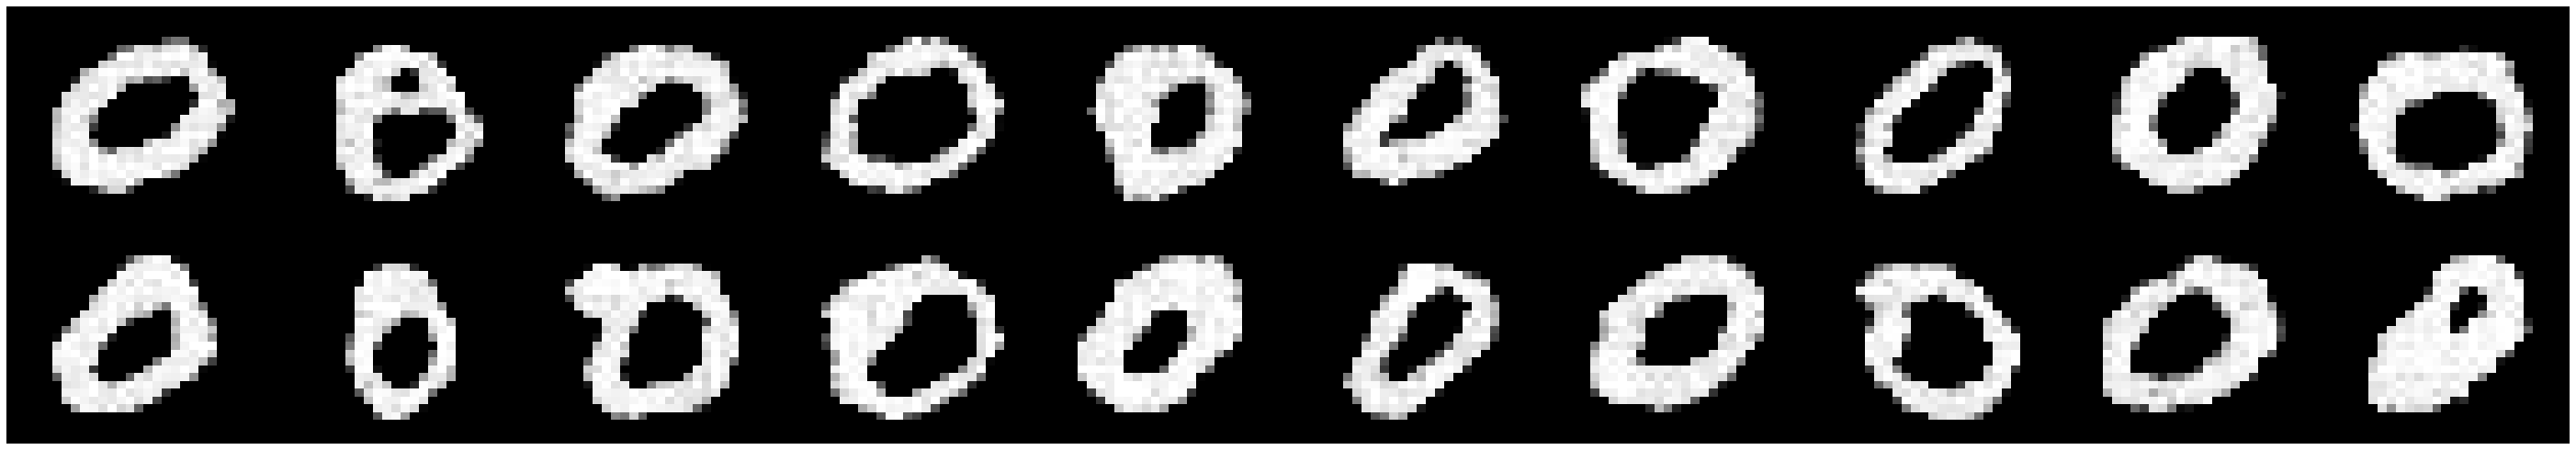

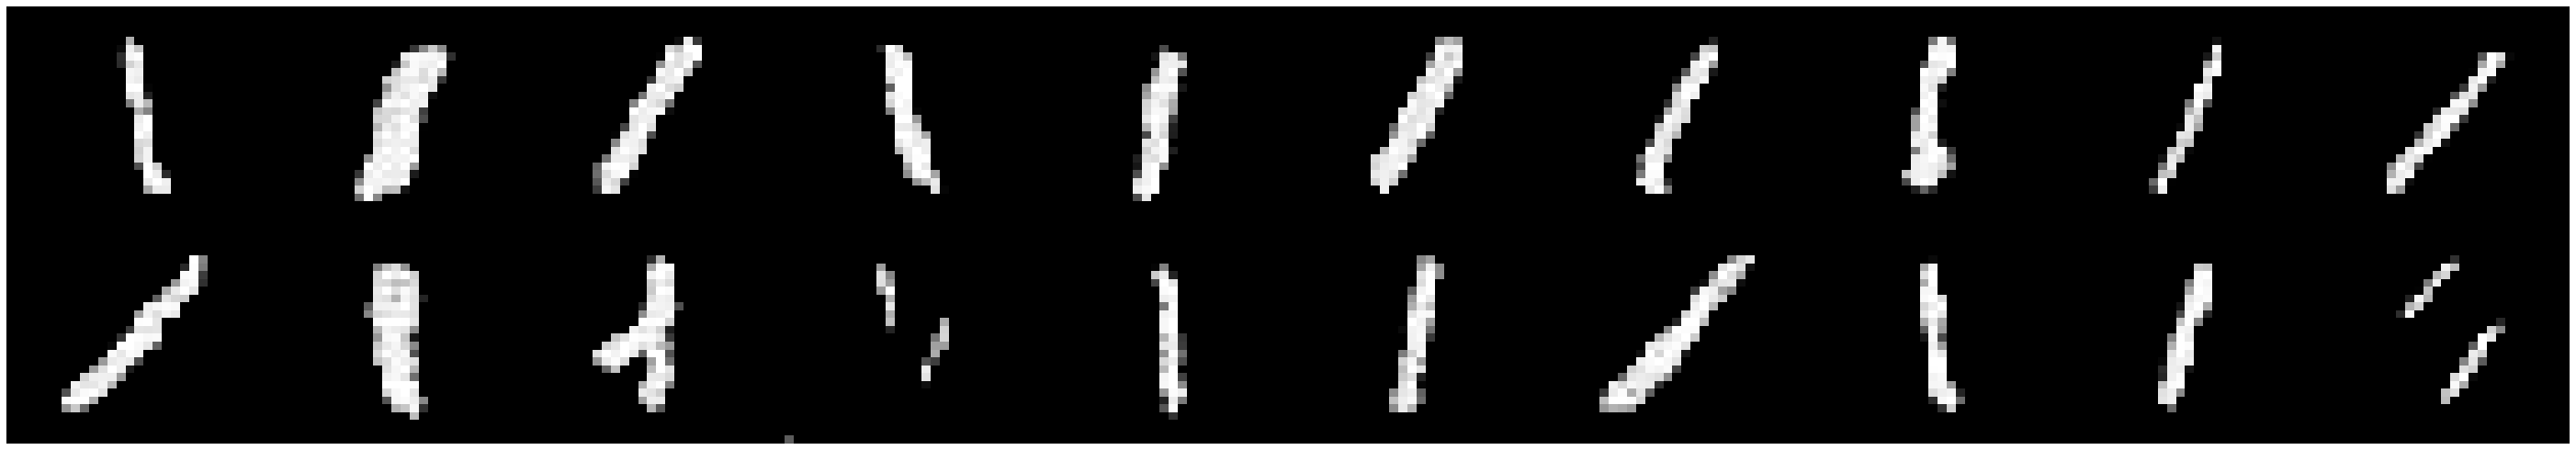

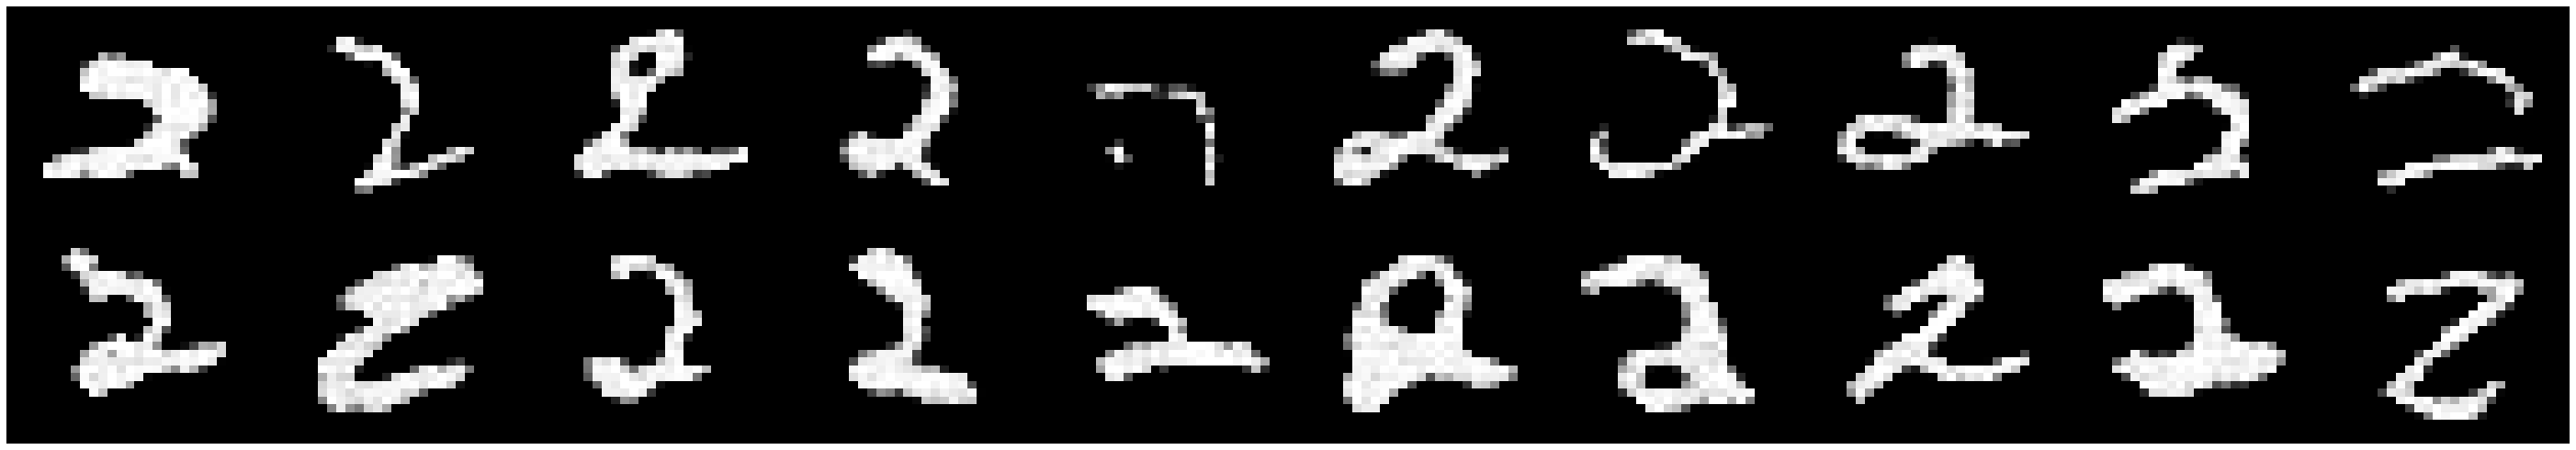

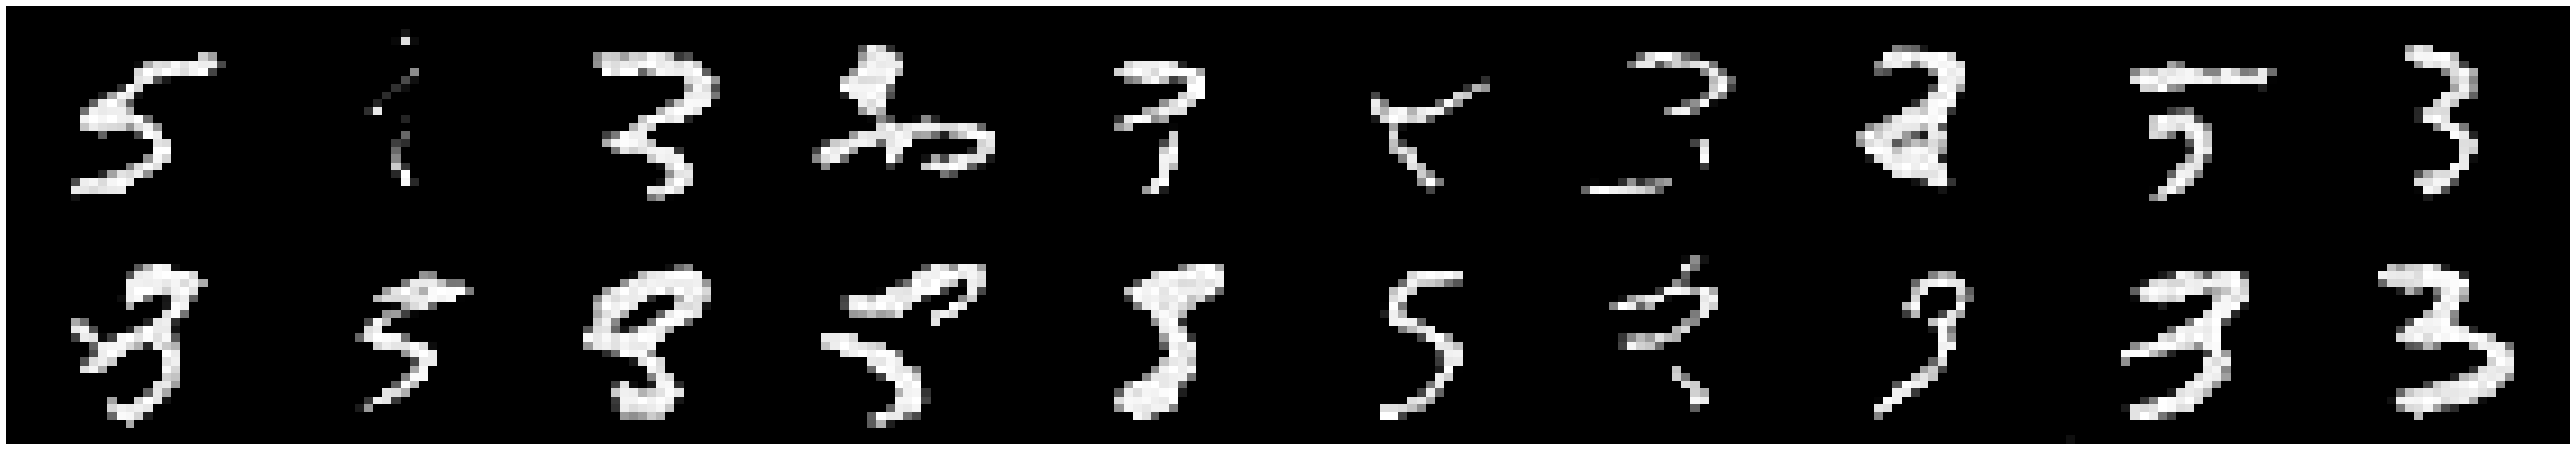

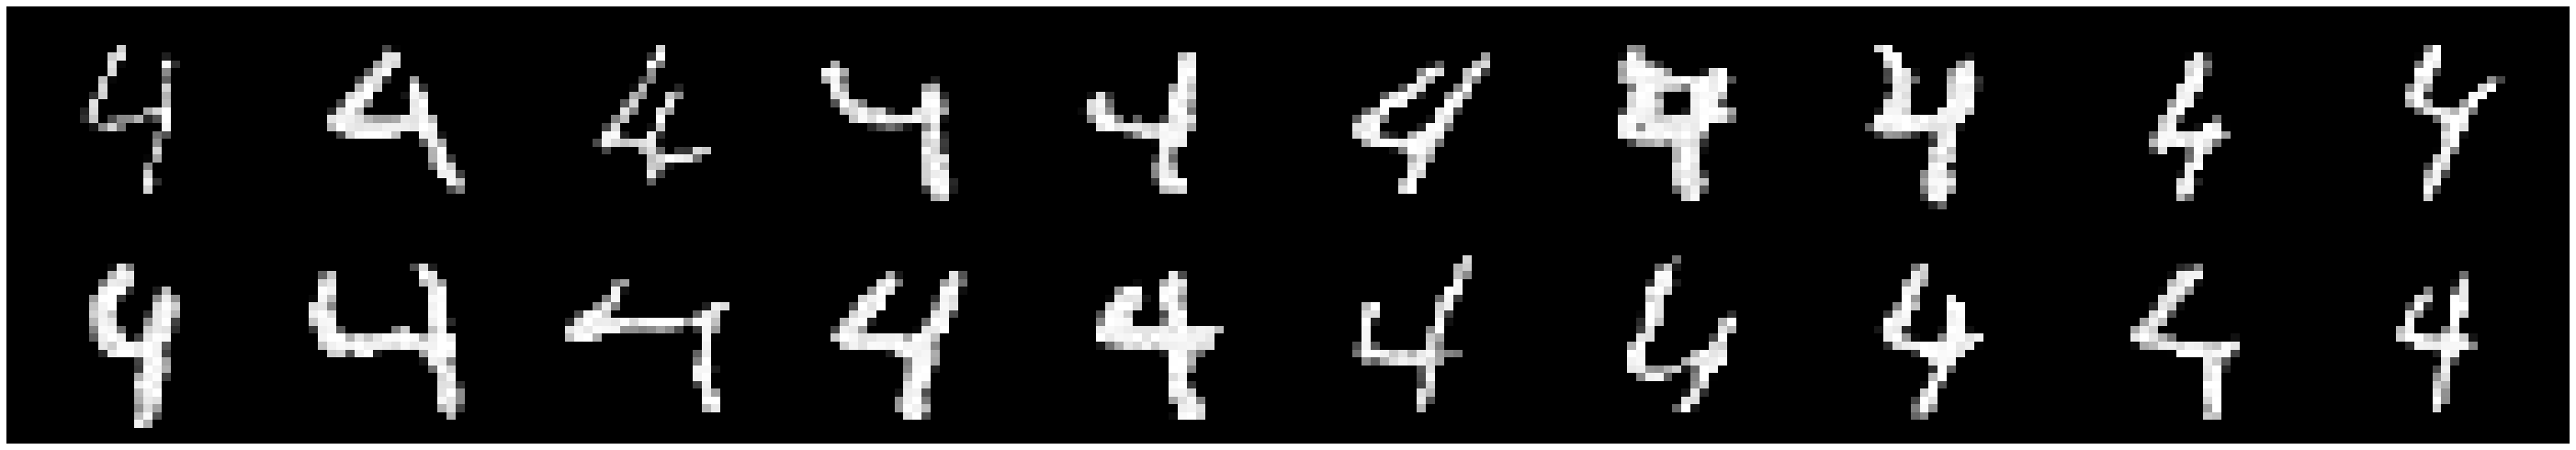

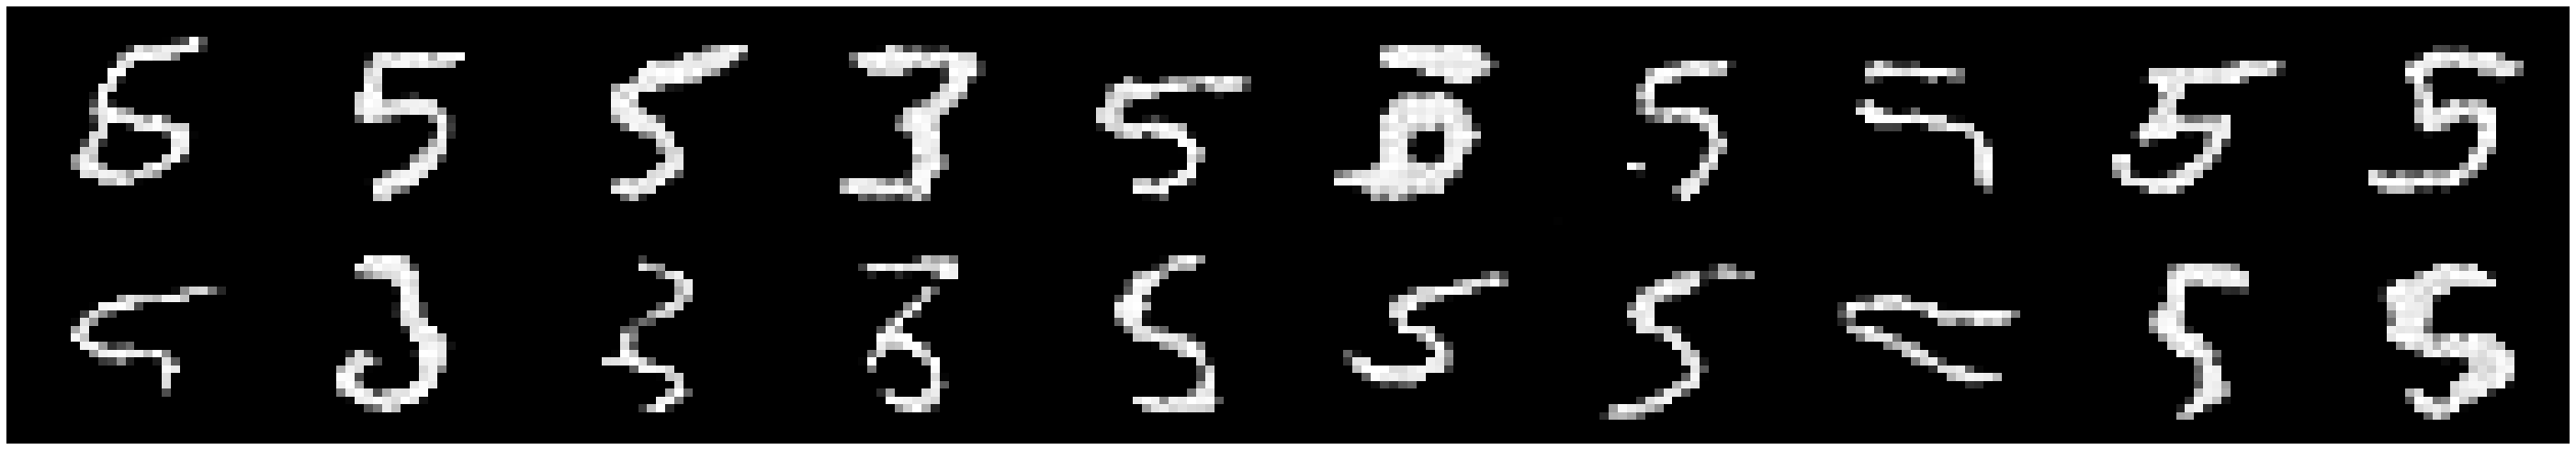

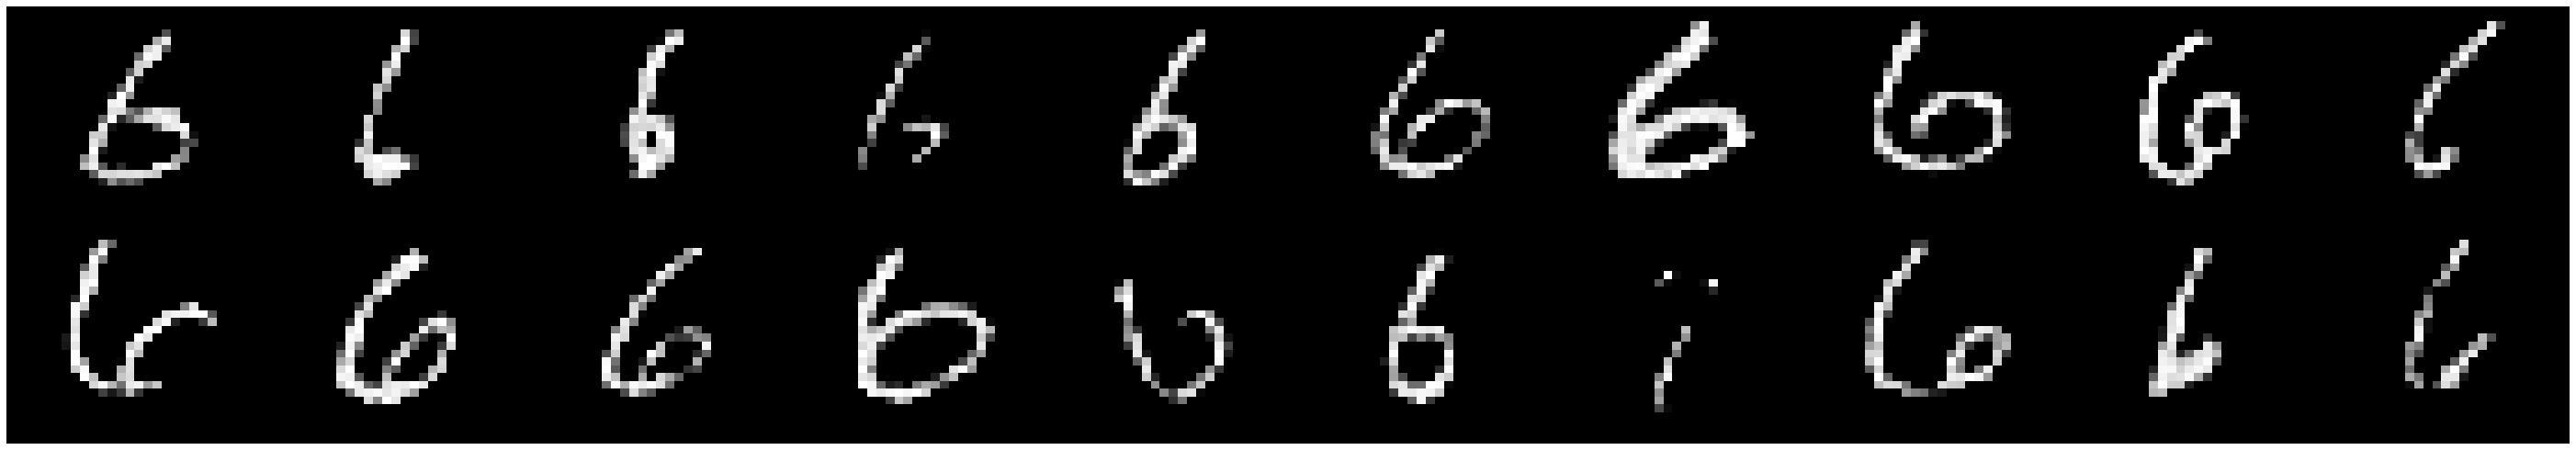

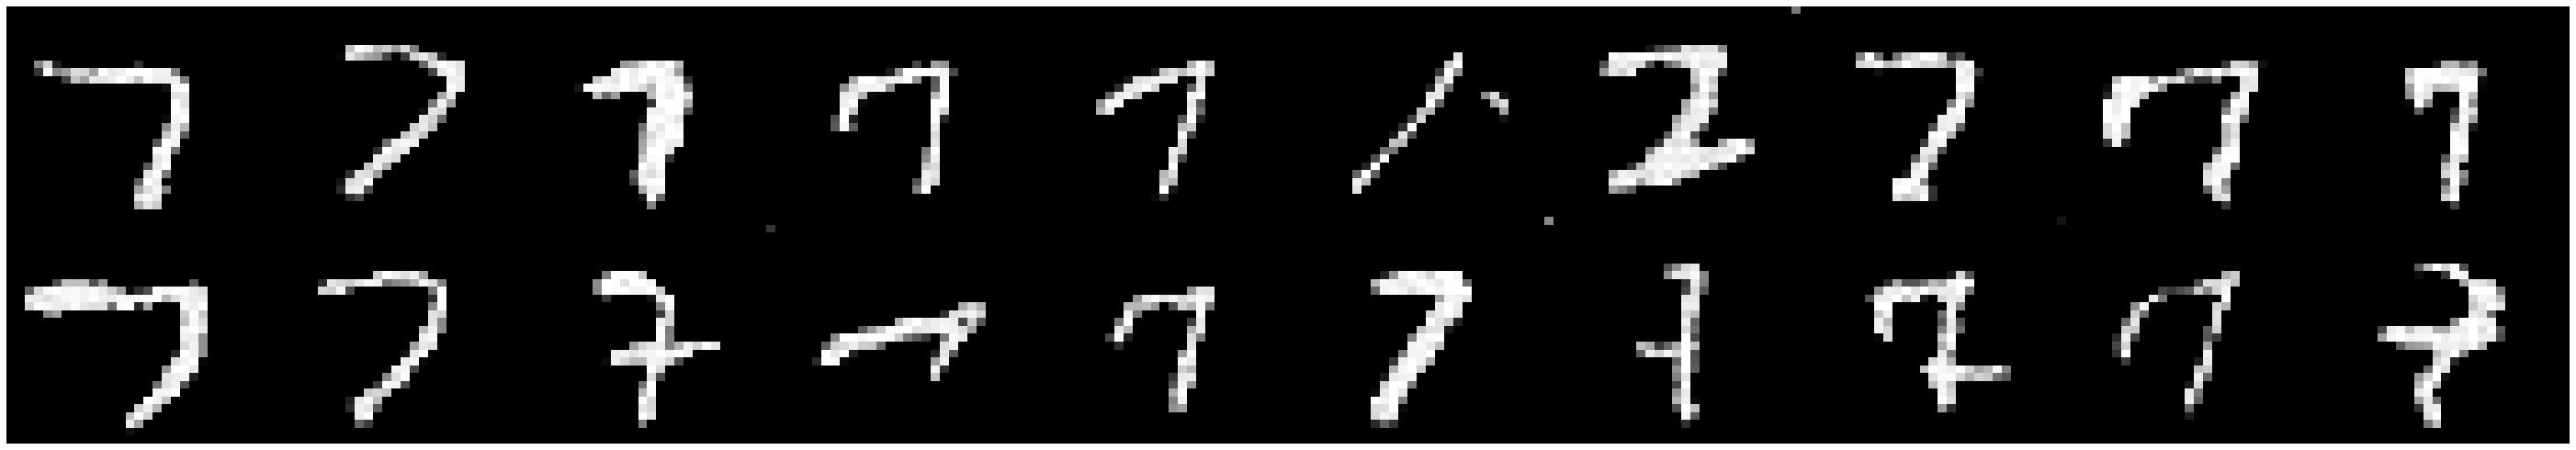

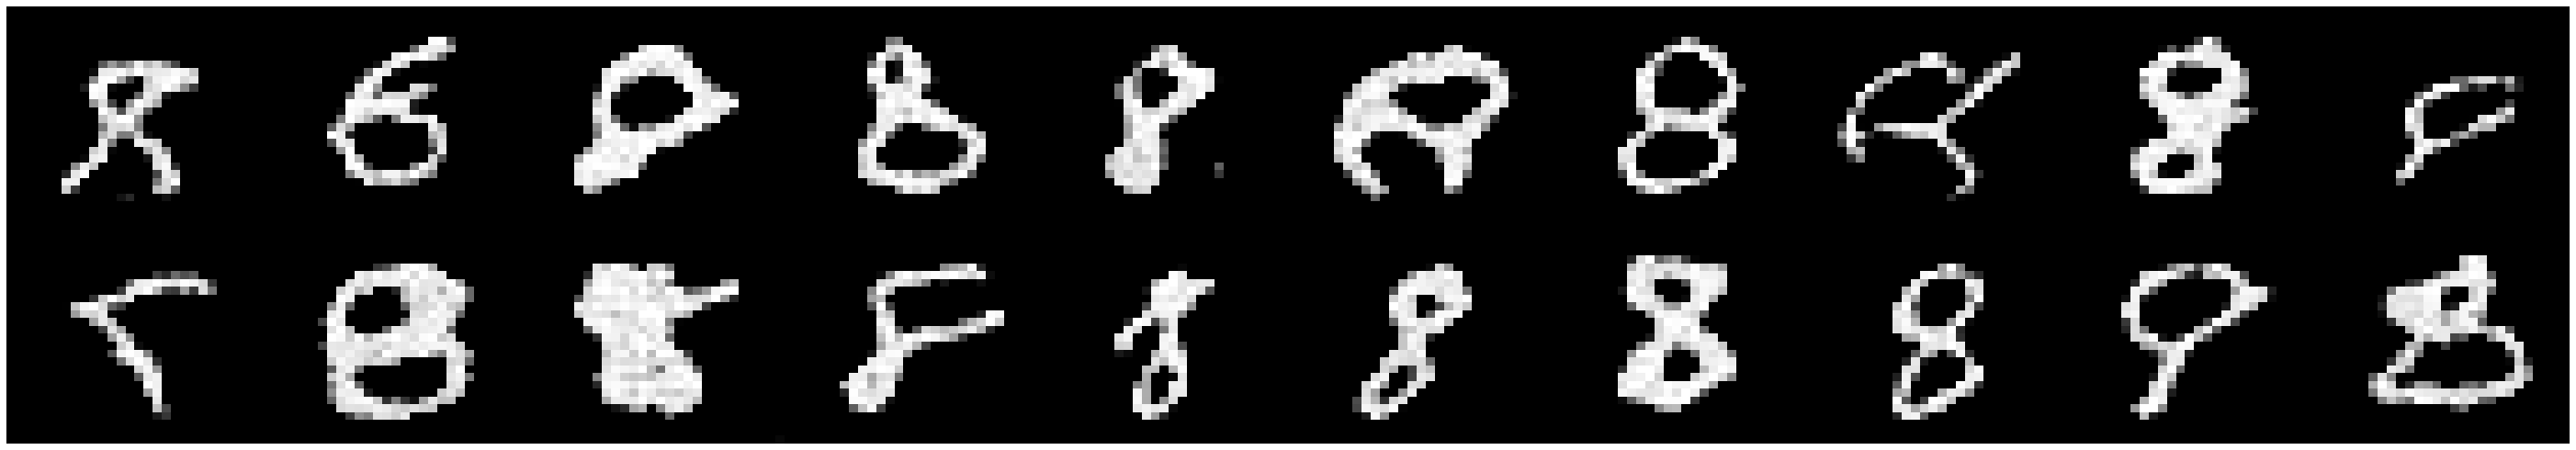

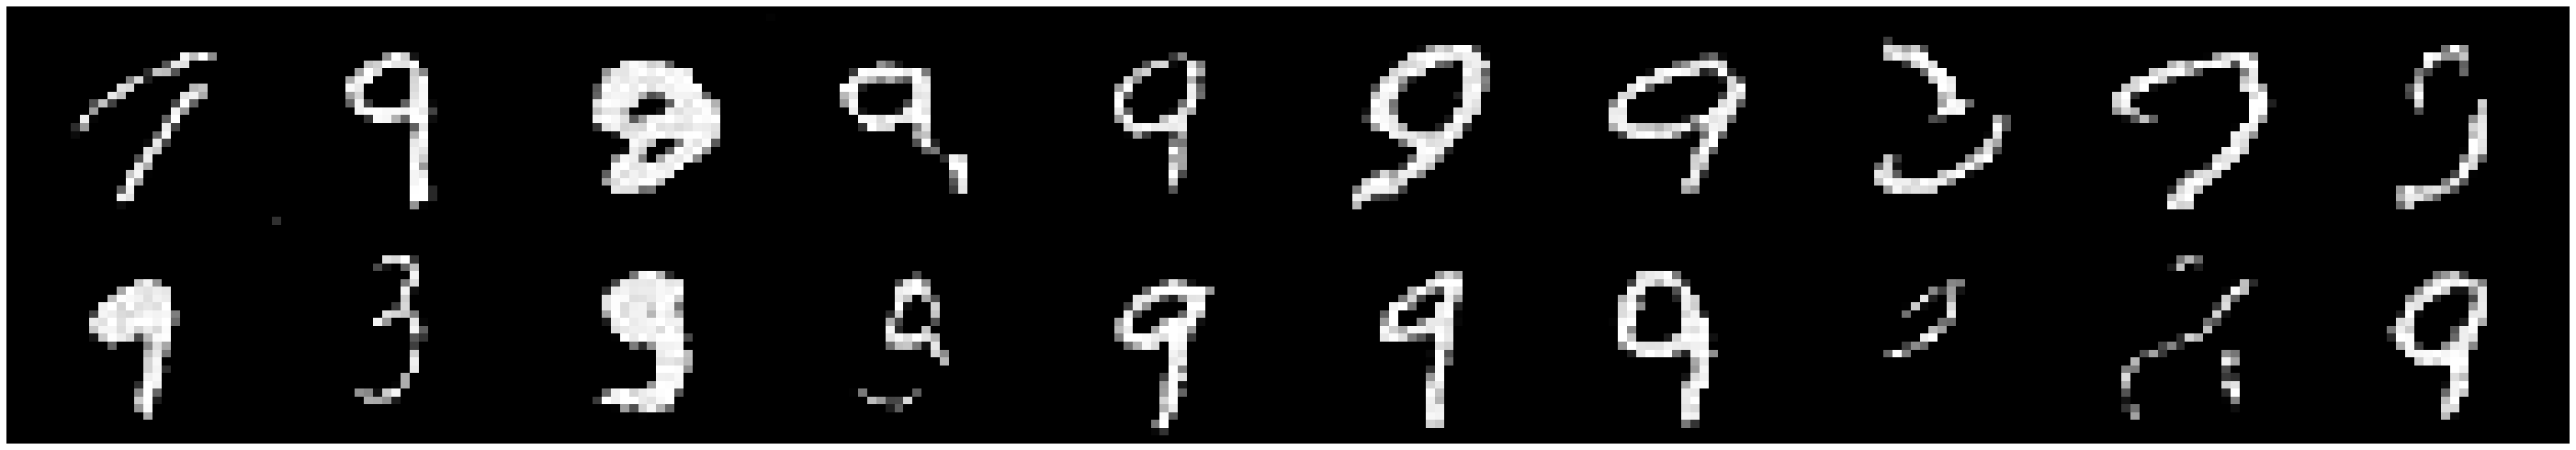

In [11]:
# Sample digits of each class from continuous model
cont_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        cont_model, cont_sde, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, cont_branch_defs),
        sampler="pc", t_limit=cont_t_limit
    ).cpu().numpy()
    cont_samples[class_to_sample] = samples
    fig = plot_mnist_digits(samples, grid_size=(10, 2), scale=5, title=None)
    fig.savefig(
        os.path.join(out_path, "cont_mnist_%d.svg" % class_to_sample),
        format="svg"
    )

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9


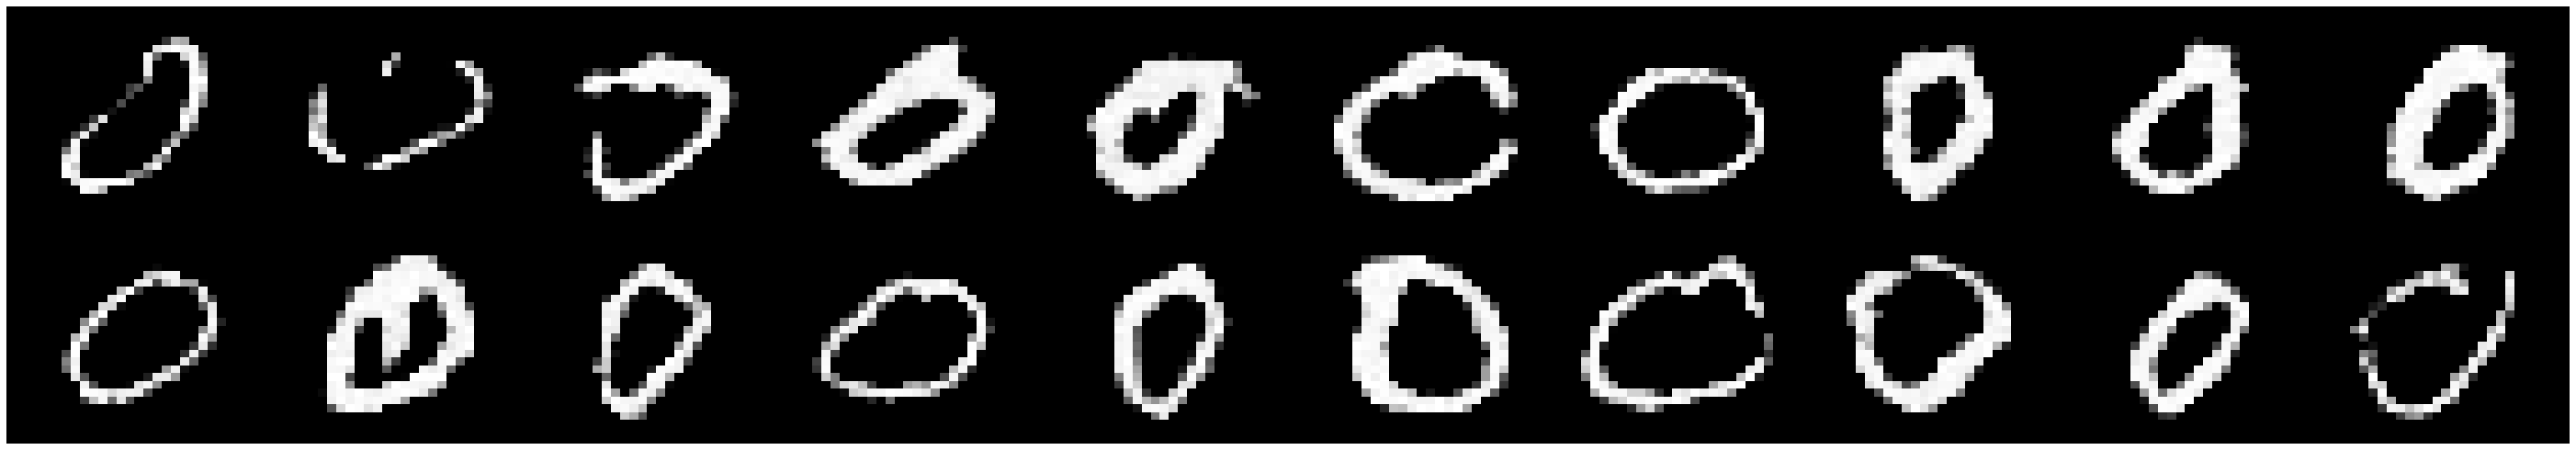

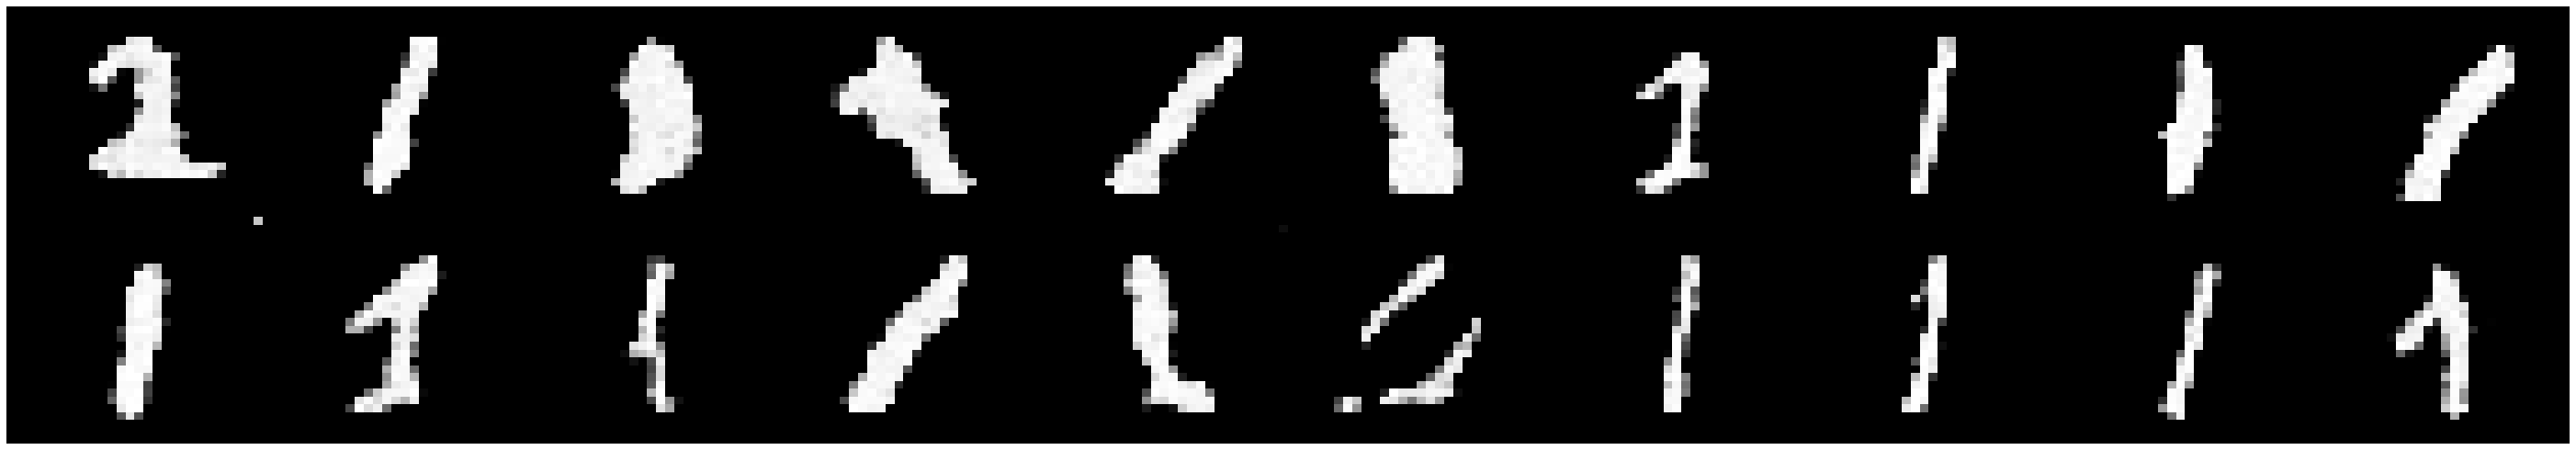

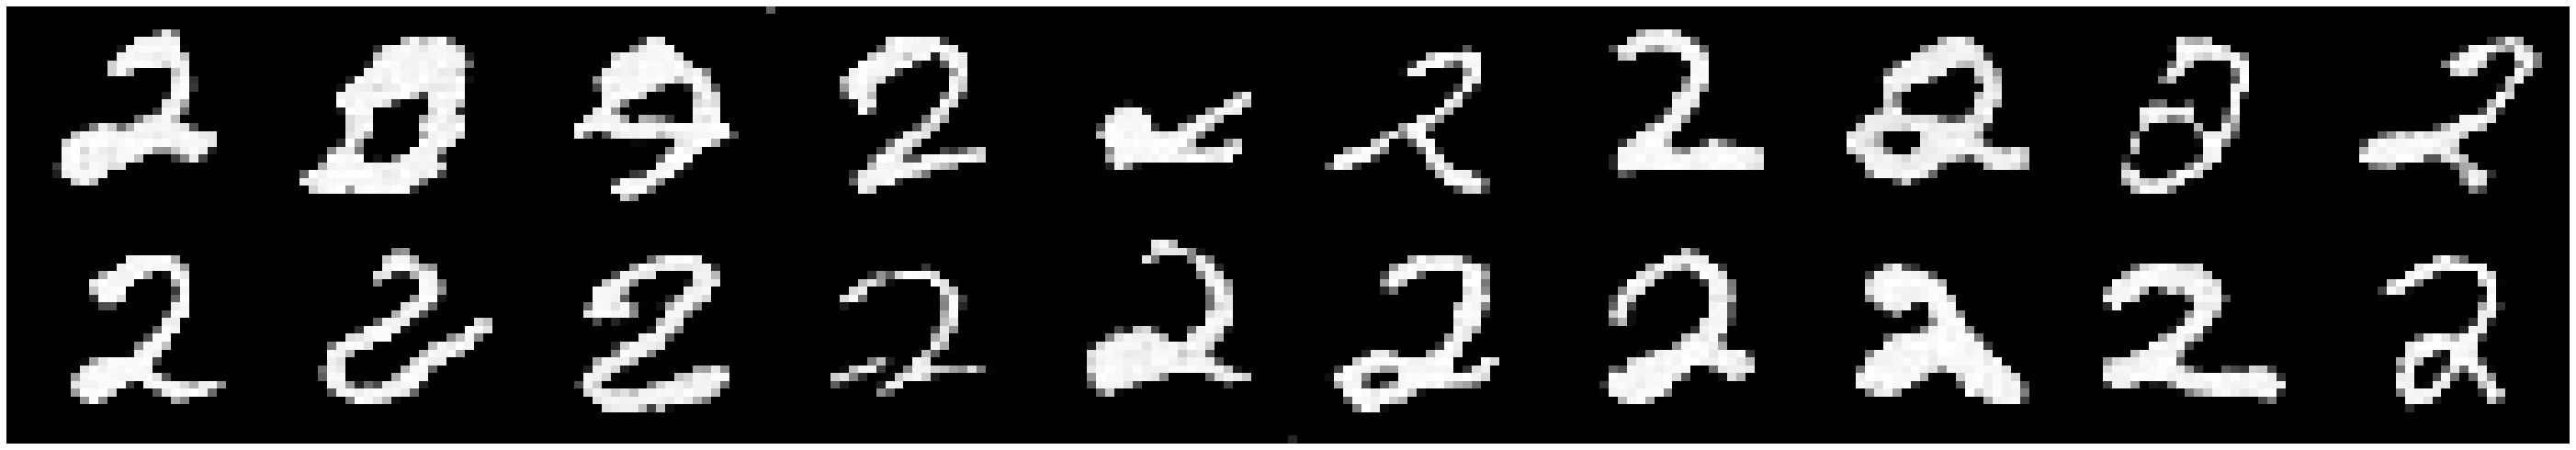

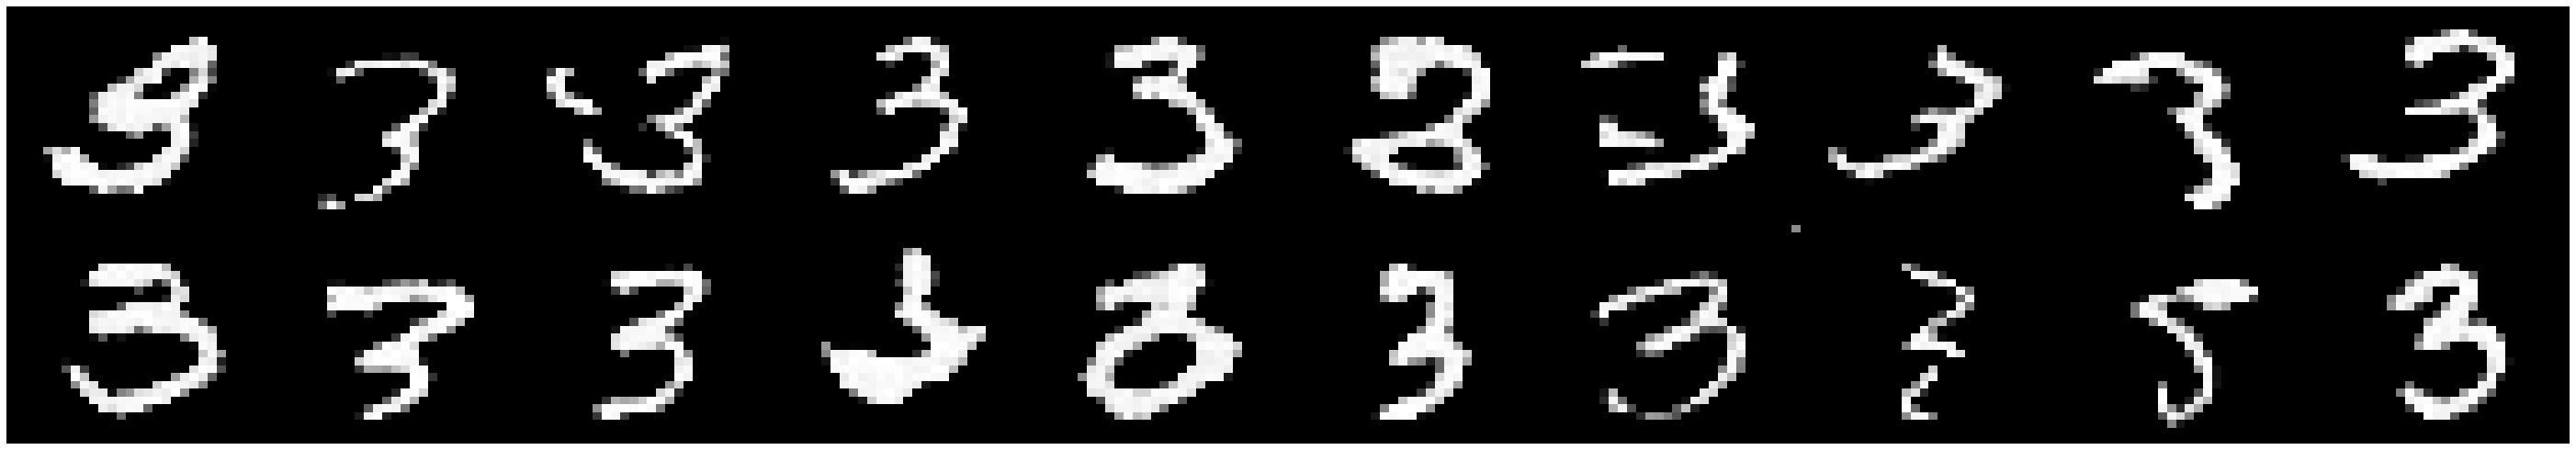

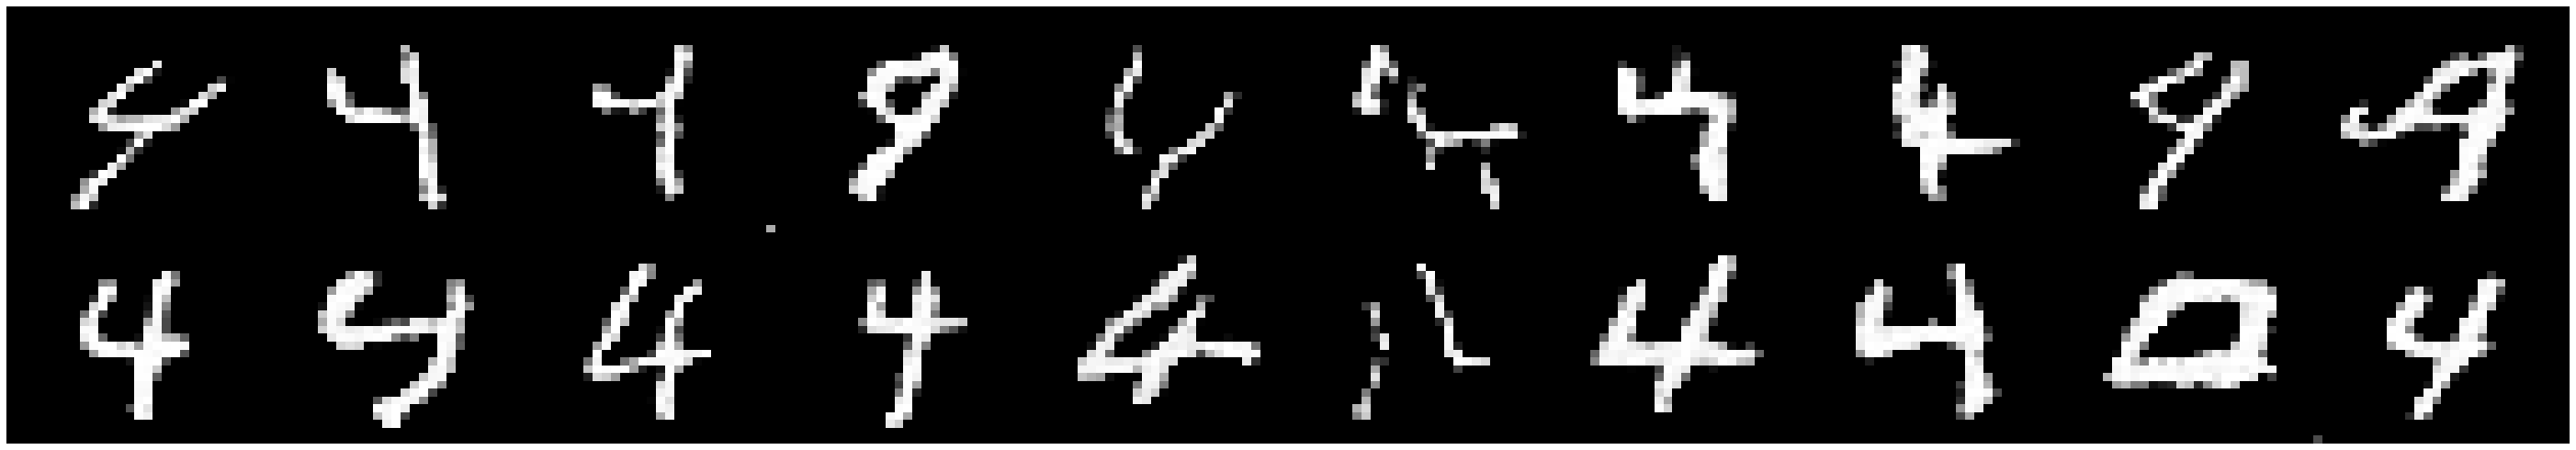

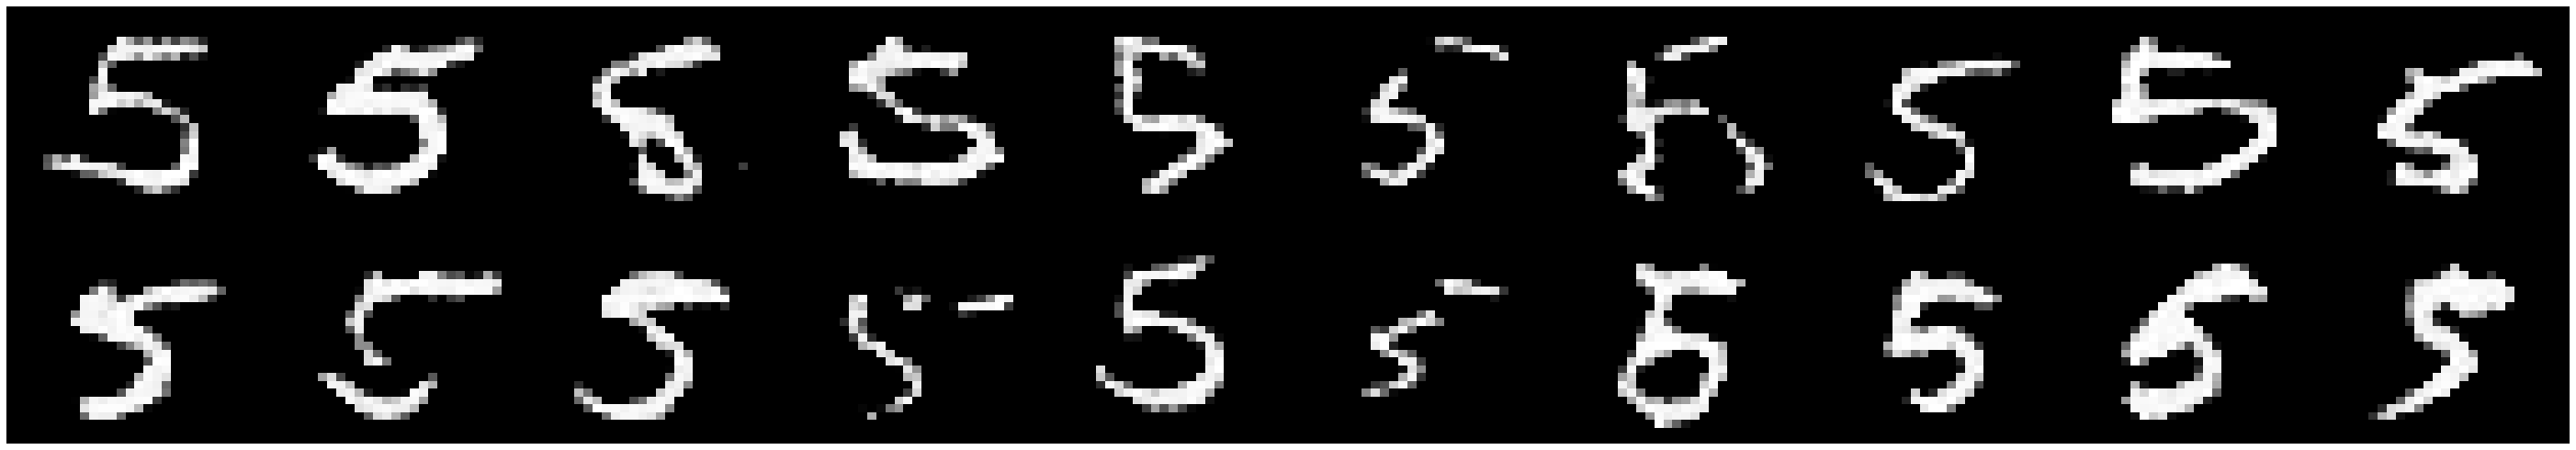

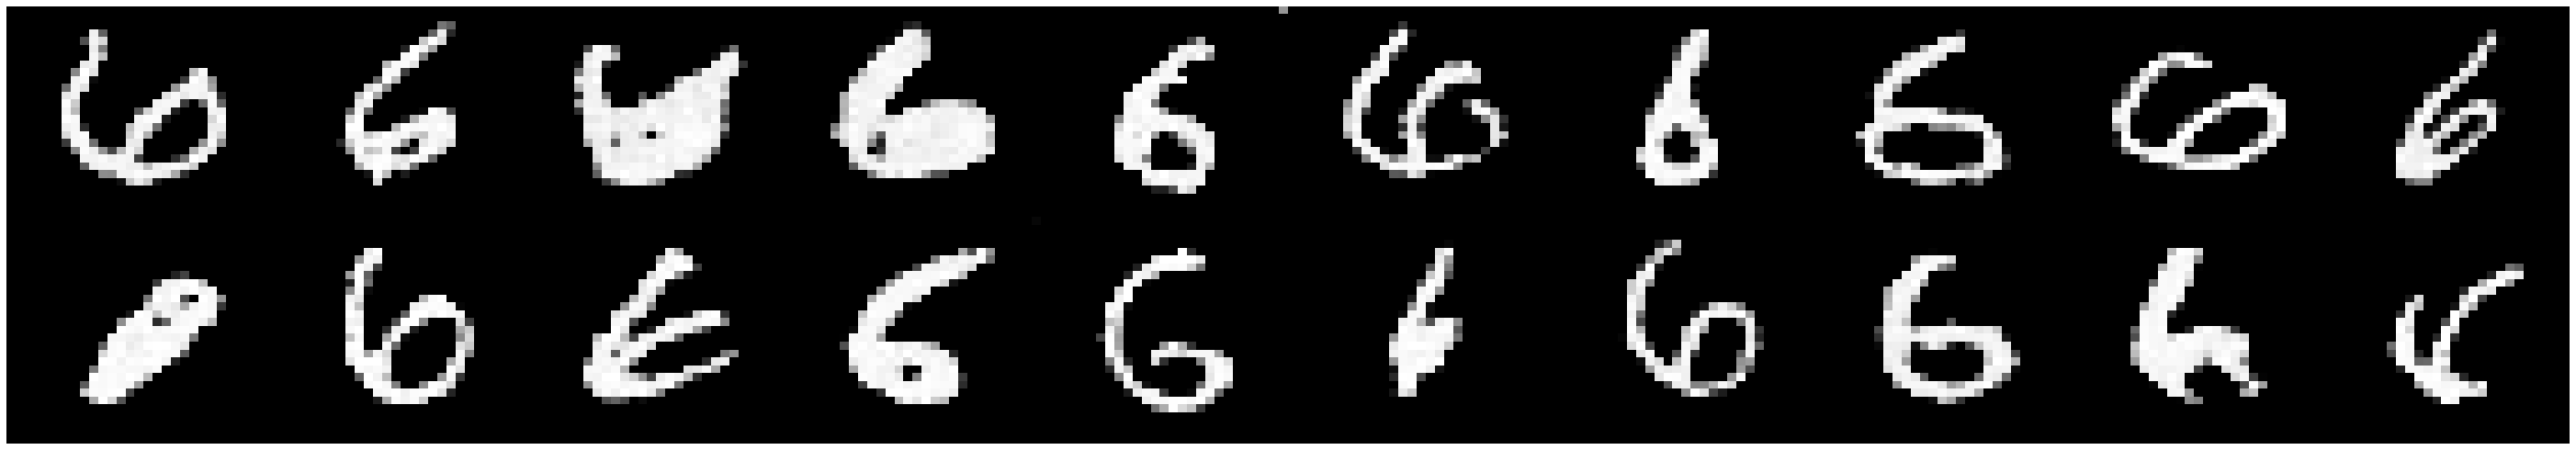

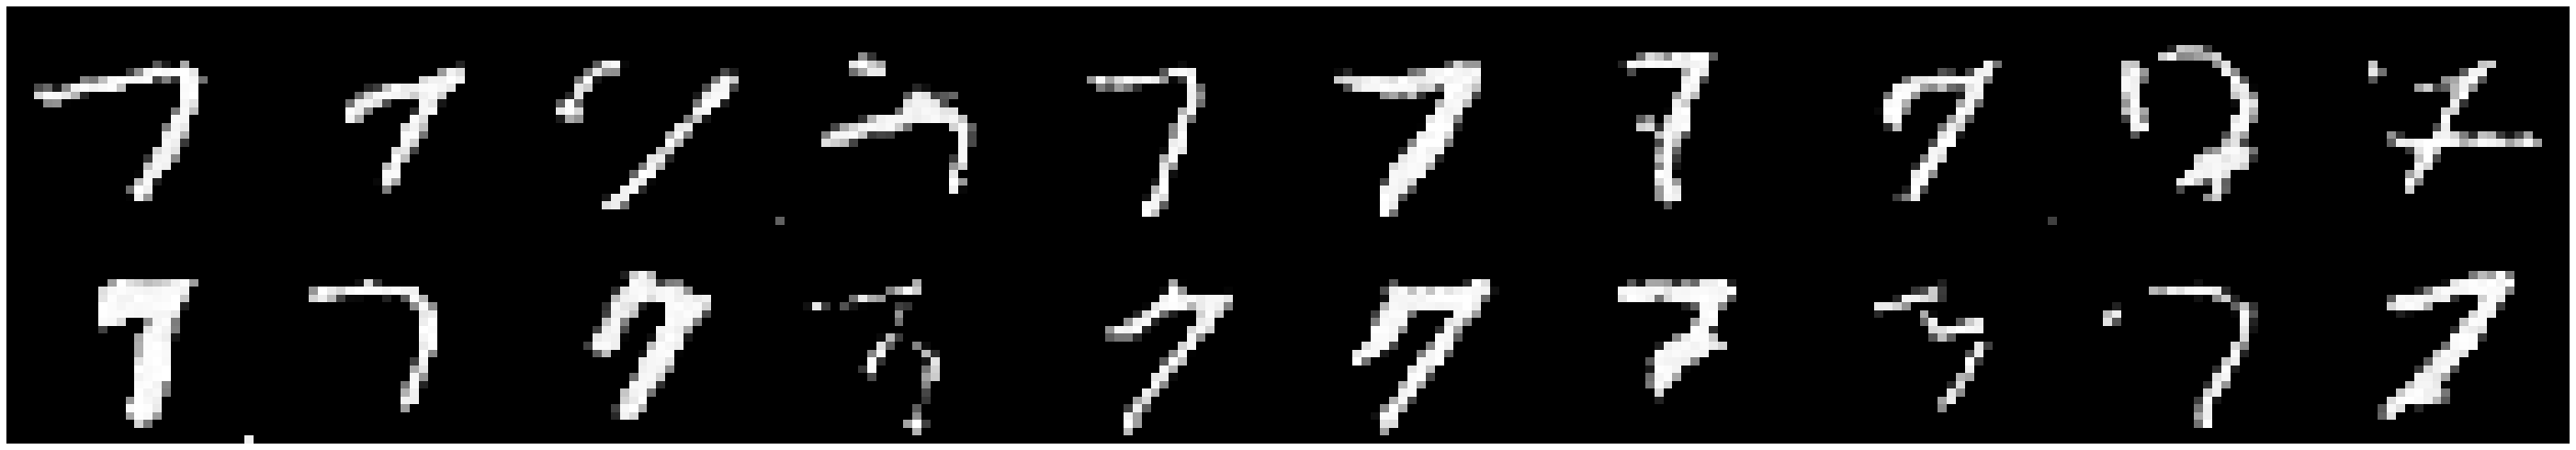

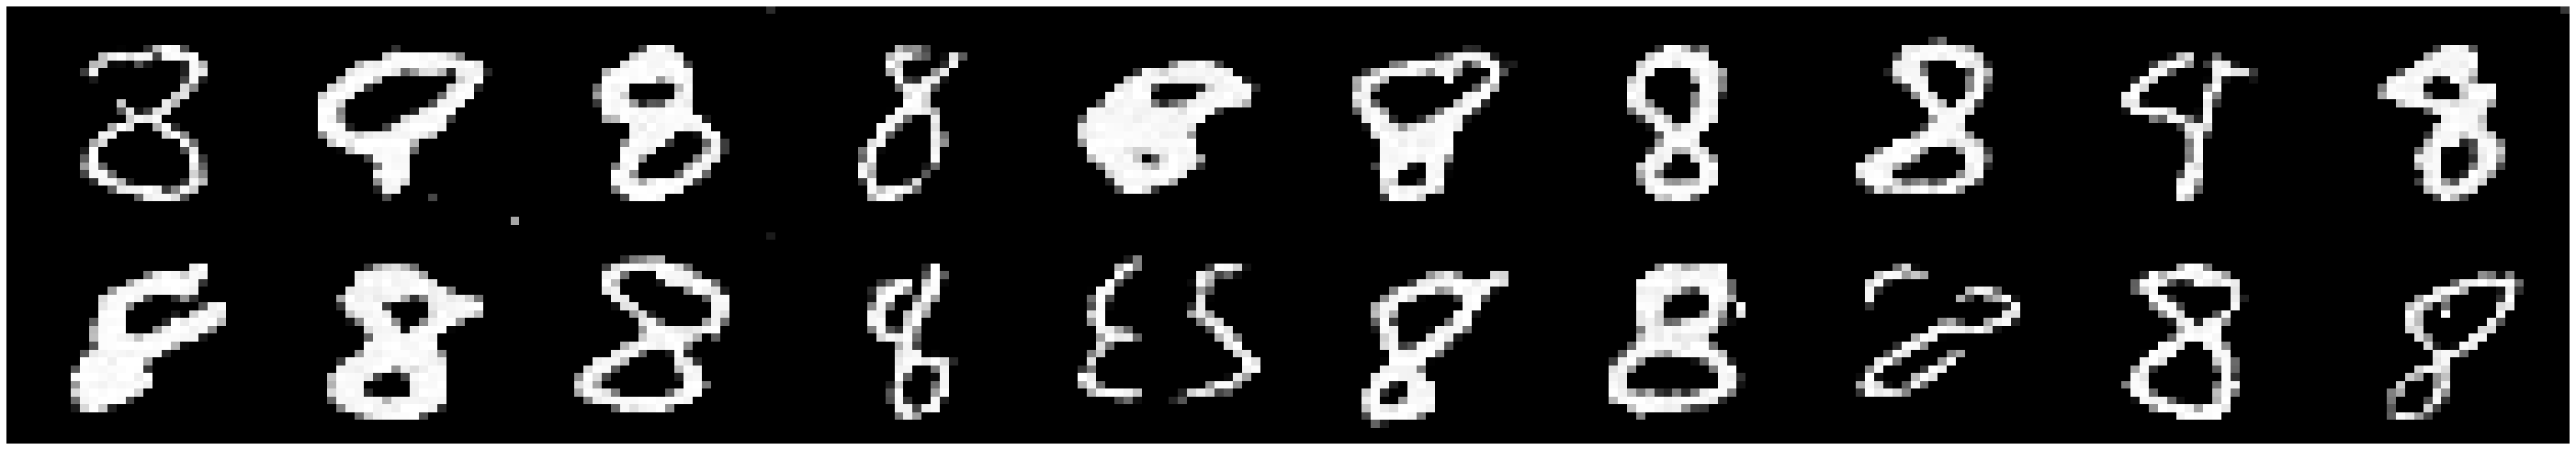

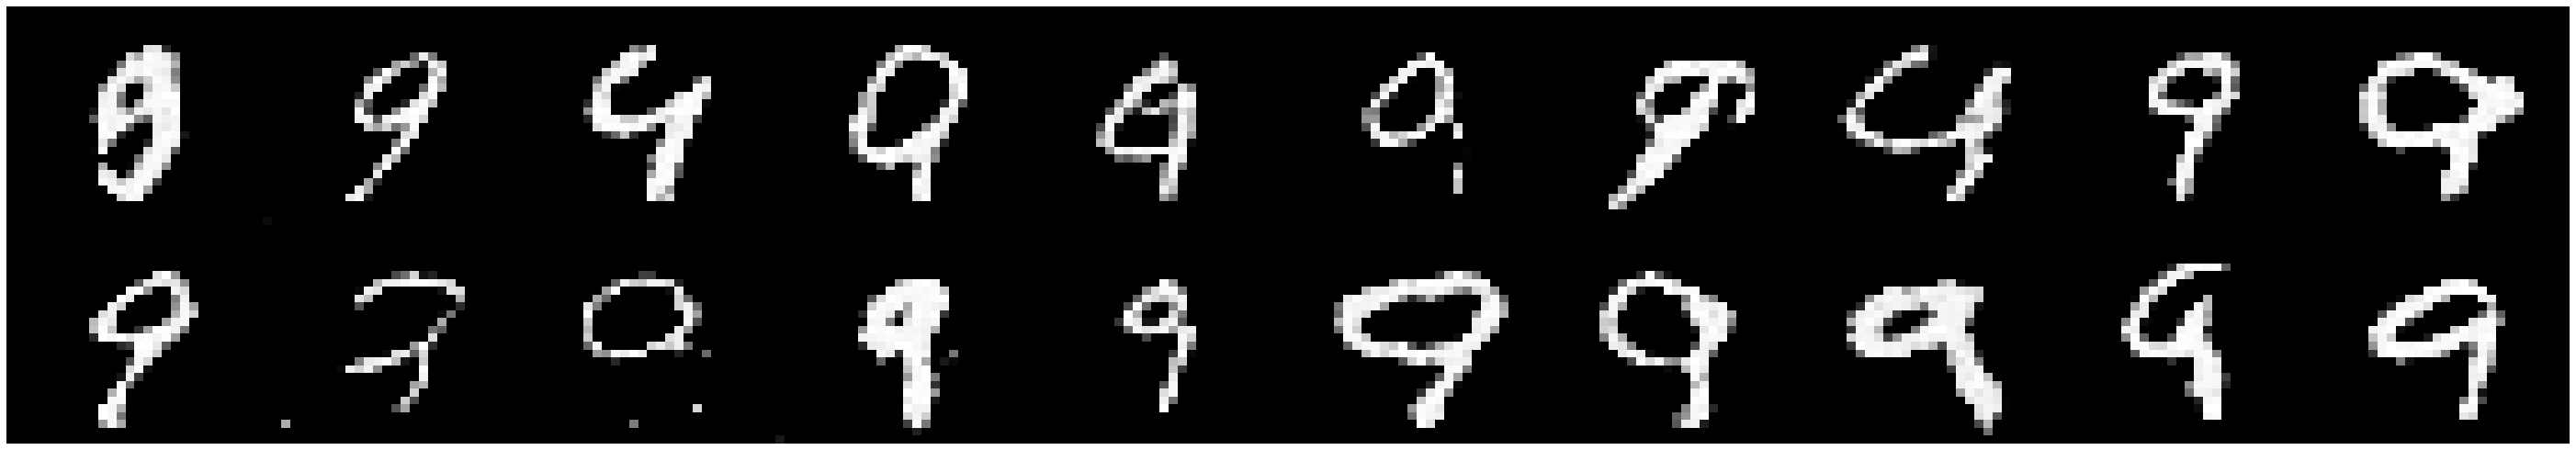

In [12]:
# Sample digits of each class from discrete model
disc_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_discrete_branched_samples(
        disc_model, disc_diffuser, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, disc_branch_defs),
        t_limit=disc_t_limit
    ).cpu().numpy()
    disc_samples[class_to_sample] = samples
    fig = plot_mnist_digits(samples, grid_size=(10, 2), scale=5, title=None)
    fig.savefig(
        os.path.join(out_path, "disc_mnist_%d.svg" % class_to_sample),
        format="svg"
    )